In [1]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import zipfile
from google.colab import files

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models, layers, optimizers, losses, callbacks
from tensorflow import keras

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img


In [2]:
# Global variables
SAVE = False
SEED = 111

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Visualization updates
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

# Data Classifications
CLASS_TYPES = ['glioma', 'meningioma', 'notumor', 'pituitary']
N_TYPES = len(CLASS_TYPES)

print("✅ Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")


✅ Libraries imported successfully!
TensorFlow version: 2.19.0


In [4]:
# Upload the dataset ZIP file
print(" Please upload your brain tumor dataset ZIP file...")
uploaded = files.upload()

# Get the uploaded file name
zip_file_name = list(uploaded.keys())[0]
print(f"\n✅ File '{zip_file_name}' uploaded successfully!")

# Unzip the dataset
print("\n Unzipping dataset...")
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('/content/')

print("✅ Dataset unzipped successfully!")

# List contents to find the correct folder name
print("\n Contents of /content/:")
for item in os.listdir('/content/'):
    print(f"  - {item}")


 Please upload your brain tumor dataset ZIP file...


Saving dataset.zip to dataset.zip

✅ File 'dataset.zip' uploaded successfully!

 Unzipping dataset...
✅ Dataset unzipped successfully!

 Contents of /content/:
  - .config
  - dataset
  - dataset.zip
  - sample_data


In [6]:
# Set up file paths for training and testing
# Adjust this based on your unzipped folder structure
USER_PATH = "/content/dataset"  # Update if your folder name is different

train_dir = os.path.join(USER_PATH, 'Training')
test_dir = os.path.join(USER_PATH, 'Testing')

# Verify paths exist
if os.path.exists(train_dir) and os.path.exists(test_dir):
    print("✅ Dataset paths found!")
    print(f"Training directory: {train_dir}")
    print(f"Testing directory: {test_dir}")

    # Show class folders
    print(f"\nTraining classes: {os.listdir(train_dir)}")
    print(f"Testing classes: {os.listdir(test_dir)}")
else:
    print("❌ Error: Dataset paths not found!")
    print("Please check the folder structure and update USER_PATH")


✅ Dataset paths found!
Training directory: /content/dataset/Training
Testing directory: /content/dataset/Testing

Training classes: ['notumor', 'glioma', 'pituitary', 'meningioma']
Testing classes: ['notumor', 'glioma', 'pituitary', 'meningioma']


In [7]:
def get_data_labels(directory):
    """Extract image paths and labels from directory structure"""
    paths = []
    labels = []

    for class_name in CLASS_TYPES:
        class_dir = os.path.join(directory, class_name)
        if os.path.exists(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    paths.append(img_path)
                    labels.append(class_name)

    return paths, labels

# Getting data using above function
train_paths, train_labels = get_data_labels(train_dir)
test_paths, test_labels = get_data_labels(test_dir)

# Printing training and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_labels)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_labels)}')


Training
Number of Paths: 5712
Number of Labels: 5712

Testing
Number of Paths: 1311
Number of Labels: 1311


Sample images from training set:


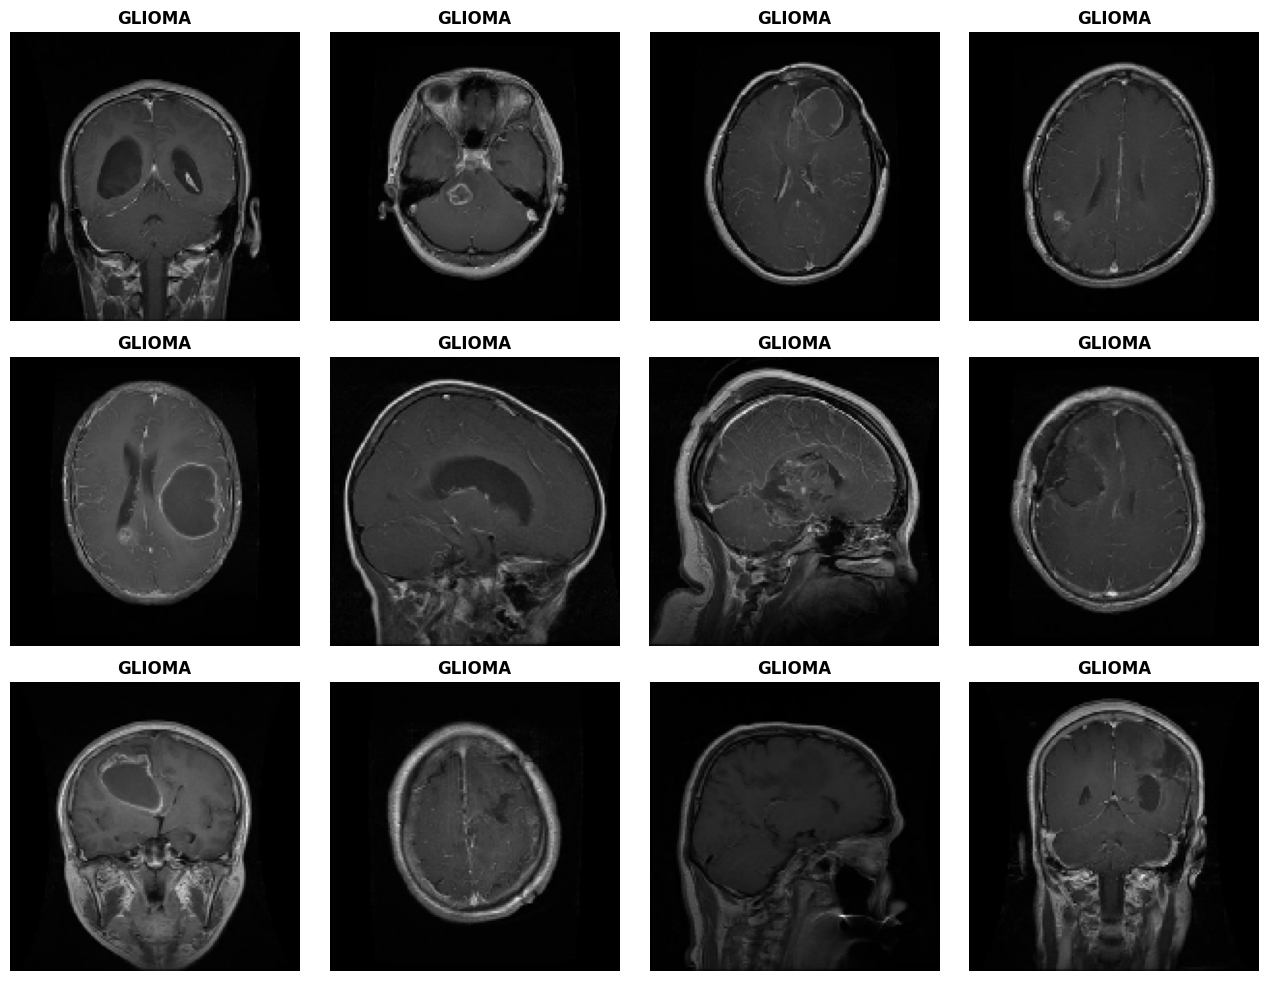

In [8]:
def show_images(paths, labels, im_size=350, figsize=(13,10), index_list=None):
    """Display a grid of images"""
    if index_list is None:
        index_list = random.sample(range(len(paths)), 12)

    fig, axes = plt.subplots(3, 4, figsize=figsize)
    axes = axes.ravel()

    for i, idx in enumerate(index_list):
        img = load_img(paths[idx], target_size=(im_size, im_size))
        axes[i].imshow(img)
        axes[i].set_title(labels[idx].upper(), fontsize=12, fontweight='bold')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Display sample images
print("Sample images from training set:")
show_images(train_paths, train_labels, im_size=150, figsize=(13,10),
            index_list=[0, 94, 235, 17, 61, 324, 55, 45, 374, 65, 391, 488])


Training Counts:
{'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}

Testing Counts:
{'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


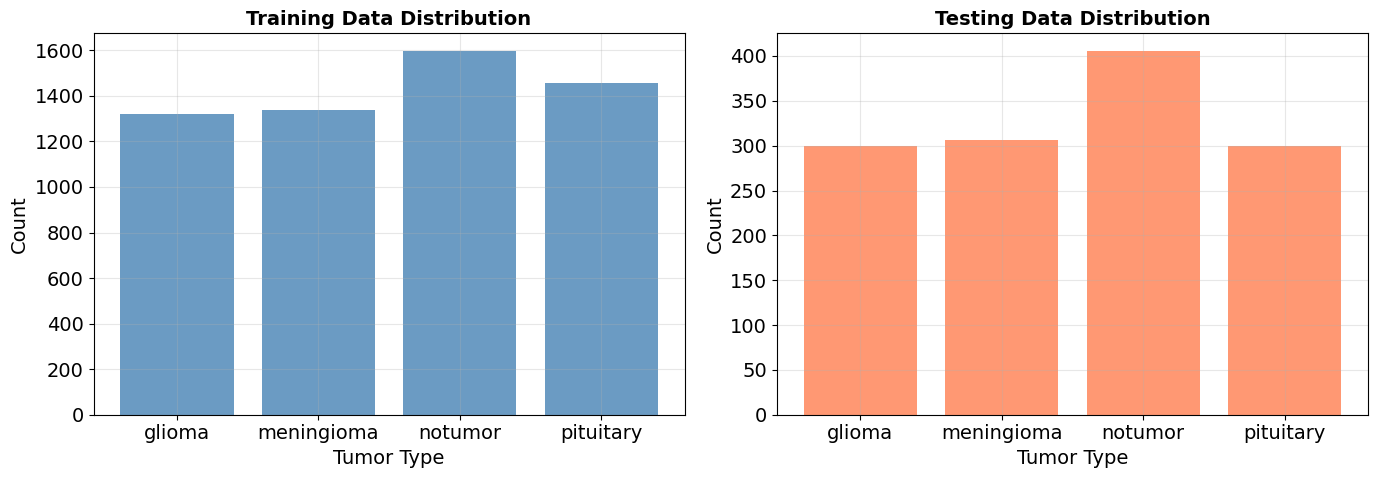

In [9]:
from collections import Counter

# Count training samples
train_counts = Counter(train_labels)
test_counts = Counter(test_labels)

print("Training Counts:")
print(dict(train_counts))
print("\nTesting Counts:")
print(dict(test_counts))

# Visualize distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Training distribution
ax1.bar(train_counts.keys(), train_counts.values(), color='steelblue', alpha=0.8)
ax1.set_title('Training Data Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Tumor Type')
ax1.set_ylabel('Count')
ax1.grid(alpha=0.3)

# Testing distribution
ax2.bar(test_counts.keys(), test_counts.values(), color='coral', alpha=0.8)
ax2.set_title('Testing Data Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Tumor Type')
ax2.set_ylabel('Count')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [10]:
# Image size - IMPORTANT: Changed to 240x240 for U-Net compatibility
image_size = (240, 240)

# Training batch size
batch_size = 16  # Reduced for U-Net (more parameters)

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    brightness_range=(0.85, 1.15),
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=12.5,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="nearest"
)

# Applying the generator to training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=SEED
)

# No augmentation of test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Applying the generator to testing data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=SEED
)

# Accessing class indices
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())

print("Categorical types for the training data:")
print(class_indices_train)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Categorical types for the training data:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [11]:
# Image shape: height, width, RGB
image_shape = (image_size[0], image_size[1], 3)

# Training epochs
epochs = 50

# Steps per epoch
steps_per_epoch = train_generator.samples // batch_size

# Validation steps
validation_steps = test_generator.samples // batch_size

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')
print(f'Steps Per Epoch: {steps_per_epoch}')
print(f'Validation steps: {validation_steps}')


Image shape: (240, 240, 3)
Epochs: 50
Batch size: 16
Steps Per Epoch: 357
Validation steps: 81


In [12]:
# Channel Attention
@keras.utils.register_keras_serializable()
class ChannelAttention(layers.Layer):
    def __init__(self, channels, reduction=16, **kwargs):
        super().__init__(**kwargs)
        self.channels = channels
        self.reduction = reduction

        self.avg_pool = layers.GlobalAveragePooling2D()
        self.max_pool = layers.GlobalMaxPooling2D()

        self.fc1 = layers.Dense(channels // reduction, use_bias=False, activation='relu')
        self.fc2 = layers.Dense(channels, use_bias=False)
        self.sigmoid = layers.Activation('sigmoid')

    def call(self, x):
        avg = self.fc2(self.fc1(self.avg_pool(x)))
        maxp = self.fc2(self.fc1(self.max_pool(x)))
        out = self.sigmoid(avg + maxp)
        out = tf.reshape(out, (-1, 1, 1, self.channels))
        return x * out

    def get_config(self):
        config = super().get_config()
        config.update({
            "channels": self.channels,
            "reduction": self.reduction
        })
        return config


# Spatial Attention
@keras.utils.register_keras_serializable()
class SpatialAttention(layers.Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super().__init__(**kwargs)
        self.kernel_size = kernel_size
        self.conv = layers.Conv2D(1, kernel_size, padding='same', use_bias=False)
        self.sigmoid = layers.Activation('sigmoid')

    def call(self, x):
        avg_out = tf.reduce_mean(x, axis=3, keepdims=True)
        max_out = tf.reduce_max(x, axis=3, keepdims=True)
        concat = tf.concat([avg_out, max_out], axis=3)
        out = self.sigmoid(self.conv(concat))
        return x * out

    def get_config(self):
        config = super().get_config()
        config.update({
            "kernel_size": self.kernel_size
        })
        return config


# CBAM Block
@keras.utils.register_keras_serializable()
class CBAM(layers.Layer):
    def __init__(self, channels, reduction=16, kernel_size=7, **kwargs):
        super().__init__(**kwargs)
        self.channels = channels
        self.reduction = reduction
        self.kernel_size = kernel_size

        self.ca = ChannelAttention(channels, reduction)
        self.sa = SpatialAttention(kernel_size)

    def call(self, x):
        x = self.ca(x)
        x = self.sa(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "channels": self.channels,
            "reduction": self.reduction,
            "kernel_size": self.kernel_size
        })
        return config

print("✅ CBAM modules defined successfully!")


✅ CBAM modules defined successfully!


In [13]:
# DoubleConv Block
def DoubleConv(x, out_channels):
    x = layers.Conv2D(out_channels, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(out_channels, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x


# UNet-CBAM Model for Multi-Class Classification
def build_unet_cbam_classifier(input_shape=(240, 240, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    enc1 = DoubleConv(inputs, 64)
    enc1 = CBAM(64)(enc1)
    p1 = layers.MaxPooling2D(2)(enc1)

    enc2 = DoubleConv(p1, 128)
    enc2 = CBAM(128)(enc2)
    p2 = layers.MaxPooling2D(2)(enc2)

    enc3 = DoubleConv(p2, 256)
    enc3 = CBAM(256)(enc3)
    p3 = layers.MaxPooling2D(2)(enc3)

    enc4 = DoubleConv(p3, 512)
    enc4 = CBAM(512)(enc4)
    p4 = layers.MaxPooling2D(2)(enc4)

    # Bottleneck
    bottleneck = DoubleConv(p4, 1024)
    bottleneck = CBAM(1024)(bottleneck)

    # Global pooling for classification (instead of decoder)
    gap = layers.GlobalAveragePooling2D()(bottleneck)

    # Classification head
    x = layers.Dense(512, activation='relu')(gap)
    x = layers.Dropout(0.5, seed=SEED)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3, seed=SEED)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, out, name="UNetCBAM_Classifier")

print("✅ U-Net + CBAM model builder defined!")


✅ U-Net + CBAM model builder defined!


In [14]:
# Build the model
model = build_unet_cbam_classifier(input_shape=image_shape, num_classes=N_TYPES)

# Display model summary
model.summary()

# Calculate trainable parameters
trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
print(f"\n Total trainable parameters: {int(trainable_params):,}")

# Compile model
LR = 1e-4  # Lower learning rate for better convergence
optimizer = optimizers.Adam(learning_rate=LR)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n✅ Model compiled successfully!")


Model: "UNetCBAM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 240, 240, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 240, 240, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 240, 240, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 240, 240, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cbam (CBAM)                     │ (None, 240, 240, 64)   │           610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 120, 120, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 120, 120, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 120, 120, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 120, 120, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cbam_1 (CBAM)                   │ (None, 120, 120, 128)  │         2,146 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 60, 60, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 60, 60, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 60, 60, 256)    │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 19,691,310 (75.12 MB)

 Trainable params: 19,683,374 (75.09 MB)

 Non-trainable params: 7,936 (31.00 KB)


 Total trainable parameters: 19,683,374

✅ Model compiled successfully!


In [15]:
# Early stopping callback
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Learning rate reducer
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-7
)

# Model checkpoint
checkpoint = callbacks.ModelCheckpoint(
    'best_unet_cbam_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

print("✅ Callbacks configured!")


✅ Callbacks configured!


In [16]:
# Training the model
print(" Starting training...\n")

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

print("\n✅ Training completed!")


 Starting training...



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.5983 - loss: 0.9580
Epoch 1: val_accuracy improved from -inf to 0.30633, saving model to best_unet_cbam_model.h5


357/357 ━━━━━━━━━━━━━━━━━━━━ 190s 389ms/step - accuracy: 0.5985 - loss: 0.9575 - val_accuracy: 0.3063 - val_loss: 2.0103 - learning_rate: 1.0000e-04
Epoch 2/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.8062 - loss: 0.5308
Epoch 2: val_accuracy improved from 0.30633 to 0.79707, saving model to best_unet_cbam_model.h5


357/357 ━━━━━━━━━━━━━━━━━━━━ 154s 374ms/step - accuracy: 0.8063 - loss: 0.5307 - val_accuracy: 0.7971 - val_loss: 0.5020 - learning_rate: 1.0000e-04
Epoch 3/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.8764 - loss: 0.3592
Epoch 3: val_accuracy improved from 0.79707 to 0.83179, saving model to best_unet_cbam_model.h5


357/357 ━━━━━━━━━━━━━━━━━━━━ 140s 391ms/step - accuracy: 0.8763 - loss: 0.3592 - val_accuracy: 0.8318 - val_loss: 0.5358 - learning_rate: 1.0000e-04
Epoch 4/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.9055 - loss: 0.2723
Epoch 4: val_accuracy did not improve from 0.83179
357/357 ━━━━━━━━━━━━━━━━━━━━ 132s 369ms/step - accuracy: 0.9055 - loss: 0.2723 - val_accuracy: 0.7099 - val_loss: 1.0476 - learning_rate: 1.0000e-04
Epoch 5/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.9160 - loss: 0.2419
Epoch 5: val_accuracy improved from 0.83179 to 0.93596, saving model to best_unet_cbam_model.h5


357/357 ━━━━━━━━━━━━━━━━━━━━ 141s 395ms/step - accuracy: 0.9160 - loss: 0.2419 - val_accuracy: 0.9360 - val_loss: 0.1913 - learning_rate: 1.0000e-04
Epoch 6/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.9328 - loss: 0.1911
Epoch 6: val_accuracy did not improve from 0.93596
357/357 ━━━━━━━━━━━━━━━━━━━━ 132s 370ms/step - accuracy: 0.9328 - loss: 0.1911 - val_accuracy: 0.8981 - val_loss: 0.2825 - learning_rate: 1.0000e-04
Epoch 7/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9366 - loss: 0.1815
Epoch 7: val_accuracy did not improve from 0.93596
357/357 ━━━━━━━━━━━━━━━━━━━━ 142s 397ms/step - accuracy: 0.9366 - loss: 0.1815 - val_accuracy: 0.8758 - val_loss: 0.3442 - learning_rate: 1.0000e-04
Epoch 8/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.9492 - loss: 0.1555
Epoch 8: val_accuracy did not improve from 0.93596
357/357 ━━━━━━━━━━━━━━━━━━━━ 142s 397ms/step - accuracy: 0.9492 - loss: 0.1555 - val_accuracy: 0.8333 - val_loss: 0.6126 - learning_rate

357/357 ━━━━━━━━━━━━━━━━━━━━ 140s 390ms/step - accuracy: 0.9522 - loss: 0.1364 - val_accuracy: 0.9568 - val_loss: 0.1453 - learning_rate: 1.0000e-04
Epoch 10/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.9596 - loss: 0.1264
Epoch 10: val_accuracy did not improve from 0.95679
357/357 ━━━━━━━━━━━━━━━━━━━━ 135s 370ms/step - accuracy: 0.9596 - loss: 0.1264 - val_accuracy: 0.8750 - val_loss: 0.3538 - learning_rate: 1.0000e-04
Epoch 11/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.9631 - loss: 0.1101
Epoch 11: val_accuracy improved from 0.95679 to 0.95988, saving model to best_unet_cbam_model.h5


357/357 ━━━━━━━━━━━━━━━━━━━━ 143s 400ms/step - accuracy: 0.9631 - loss: 0.1101 - val_accuracy: 0.9599 - val_loss: 0.1051 - learning_rate: 1.0000e-04
Epoch 12/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9645 - loss: 0.1026
Epoch 12: val_accuracy improved from 0.95988 to 0.96528, saving model to best_unet_cbam_model.h5


357/357 ━━━━━━━━━━━━━━━━━━━━ 155s 434ms/step - accuracy: 0.9645 - loss: 0.1026 - val_accuracy: 0.9653 - val_loss: 0.0900 - learning_rate: 1.0000e-04
Epoch 13/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.9721 - loss: 0.0866
Epoch 13: val_accuracy did not improve from 0.96528
357/357 ━━━━━━━━━━━━━━━━━━━━ 133s 373ms/step - accuracy: 0.9721 - loss: 0.0867 - val_accuracy: 0.8920 - val_loss: 0.3024 - learning_rate: 1.0000e-04
Epoch 14/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9690 - loss: 0.0977
Epoch 14: val_accuracy did not improve from 0.96528
357/357 ━━━━━━━━━━━━━━━━━━━━ 133s 371ms/step - accuracy: 0.9690 - loss: 0.0977 - val_accuracy: 0.9591 - val_loss: 0.1020 - learning_rate: 1.0000e-04
Epoch 15/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.9688 - loss: 0.0904
Epoch 15: val_accuracy improved from 0.96528 to 0.97608, saving model to best_unet_cbam_model.h5


357/357 ━━━━━━━━━━━━━━━━━━━━ 149s 416ms/step - accuracy: 0.9688 - loss: 0.0904 - val_accuracy: 0.9761 - val_loss: 0.0614 - learning_rate: 1.0000e-04
Epoch 16/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9757 - loss: 0.0820
Epoch 16: val_accuracy did not improve from 0.97608
357/357 ━━━━━━━━━━━━━━━━━━━━ 133s 371ms/step - accuracy: 0.9757 - loss: 0.0821 - val_accuracy: 0.7739 - val_loss: 0.7792 - learning_rate: 1.0000e-04
Epoch 17/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.9712 - loss: 0.0828
Epoch 17: val_accuracy did not improve from 0.97608
357/357 ━━━━━━━━━━━━━━━━━━━━ 134s 374ms/step - accuracy: 0.9712 - loss: 0.0828 - val_accuracy: 0.9653 - val_loss: 0.0968 - learning_rate: 1.0000e-04
Epoch 18/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.9790 - loss: 0.0712
Epoch 18: val_accuracy did not improve from 0.97608
357/357 ━━━━━━━━━━━━━━━━━━━━ 132s 370ms/step - accuracy: 0.9790 - loss: 0.0712 - val_accuracy: 0.9352 - val_loss: 0.1737 - learnin

357/357 ━━━━━━━━━━━━━━━━━━━━ 137s 382ms/step - accuracy: 0.9860 - loss: 0.0414 - val_accuracy: 0.9861 - val_loss: 0.0344 - learning_rate: 5.0000e-05
Epoch 22/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9923 - loss: 0.0237
Epoch 22: val_accuracy improved from 0.98611 to 0.99151, saving model to best_unet_cbam_model.h5


357/357 ━━━━━━━━━━━━━━━━━━━━ 145s 392ms/step - accuracy: 0.9923 - loss: 0.0237 - val_accuracy: 0.9915 - val_loss: 0.0259 - learning_rate: 5.0000e-05
Epoch 23/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9898 - loss: 0.0297
Epoch 23: val_accuracy did not improve from 0.99151
357/357 ━━━━━━━━━━━━━━━━━━━━ 133s 371ms/step - accuracy: 0.9898 - loss: 0.0297 - val_accuracy: 0.9869 - val_loss: 0.0392 - learning_rate: 5.0000e-05
Epoch 24/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.9913 - loss: 0.0240
Epoch 24: val_accuracy did not improve from 0.99151
357/357 ━━━━━━━━━━━━━━━━━━━━ 132s 369ms/step - accuracy: 0.9913 - loss: 0.0240 - val_accuracy: 0.9383 - val_loss: 0.2016 - learning_rate: 5.0000e-05
Epoch 25/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.9911 - loss: 0.0292
Epoch 25: val_accuracy did not improve from 0.99151
357/357 ━━━━━━━━━━━━━━━━━━━━ 132s 370ms/step - accuracy: 0.9911 - loss: 0.0292 - val_accuracy: 0.9915 - val_loss: 0.0233 - learnin

357/357 ━━━━━━━━━━━━━━━━━━━━ 139s 389ms/step - accuracy: 0.9931 - loss: 0.0213 - val_accuracy: 0.9923 - val_loss: 0.0202 - learning_rate: 5.0000e-05
Epoch 29/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.9935 - loss: 0.0210
Epoch 29: val_accuracy did not improve from 0.99228
357/357 ━━━━━━━━━━━━━━━━━━━━ 135s 378ms/step - accuracy: 0.9935 - loss: 0.0210 - val_accuracy: 0.9915 - val_loss: 0.0233 - learning_rate: 5.0000e-05
Epoch 30/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.9888 - loss: 0.0356
Epoch 30: val_accuracy did not improve from 0.99228
357/357 ━━━━━━━━━━━━━━━━━━━━ 132s 370ms/step - accuracy: 0.9888 - loss: 0.0356 - val_accuracy: 0.9660 - val_loss: 0.0858 - learning_rate: 5.0000e-05
Epoch 31/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9901 - loss: 0.0305
Epoch 31: val_accuracy did not improve from 0.99228
357/357 ━━━━━━━━━━━━━━━━━━━━ 133s 371ms/step - accuracy: 0.9901 - loss: 0.0305 - val_accuracy: 0.9915 - val_loss: 0.0400 - learnin

357/357 ━━━━━━━━━━━━━━━━━━━━ 139s 390ms/step - accuracy: 0.9942 - loss: 0.0199 - val_accuracy: 0.9985 - val_loss: 0.0092 - learning_rate: 2.5000e-05
Epoch 35/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.9969 - loss: 0.0124
Epoch 35: val_accuracy did not improve from 0.99846
357/357 ━━━━━━━━━━━━━━━━━━━━ 132s 370ms/step - accuracy: 0.9969 - loss: 0.0123 - val_accuracy: 0.9946 - val_loss: 0.0156 - learning_rate: 2.5000e-05
Epoch 36/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.9971 - loss: 0.0100
Epoch 36: val_accuracy did not improve from 0.99846
357/357 ━━━━━━━━━━━━━━━━━━━━ 142s 397ms/step - accuracy: 0.9971 - loss: 0.0100 - val_accuracy: 0.9969 - val_loss: 0.0113 - learning_rate: 2.5000e-05
Epoch 37/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9986 - loss: 0.0058
Epoch 37: val_accuracy did not improve from 0.99846
357/357 ━━━━━━━━━━━━━━━━━━━━ 133s 371ms/step - accuracy: 0.9986 - loss: 0.0058 - val_accuracy: 0.9915 - val_loss: 0.0213 - learnin

In [17]:
# Evaluating the model
print(" Evaluating model on test set...\n")

loss, accuracy = model.evaluate(test_generator, steps=validation_steps)

print(f"Test Loss: {loss:.5f}")
print(f"Test Accuracy: {accuracy:.5f} ({accuracy*100:.2f}%)")


 Evaluating model on test set...

81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - accuracy: 0.9973 - loss: 0.0076
Test Loss: 0.00568
Test Accuracy: 0.99769 (99.77%)


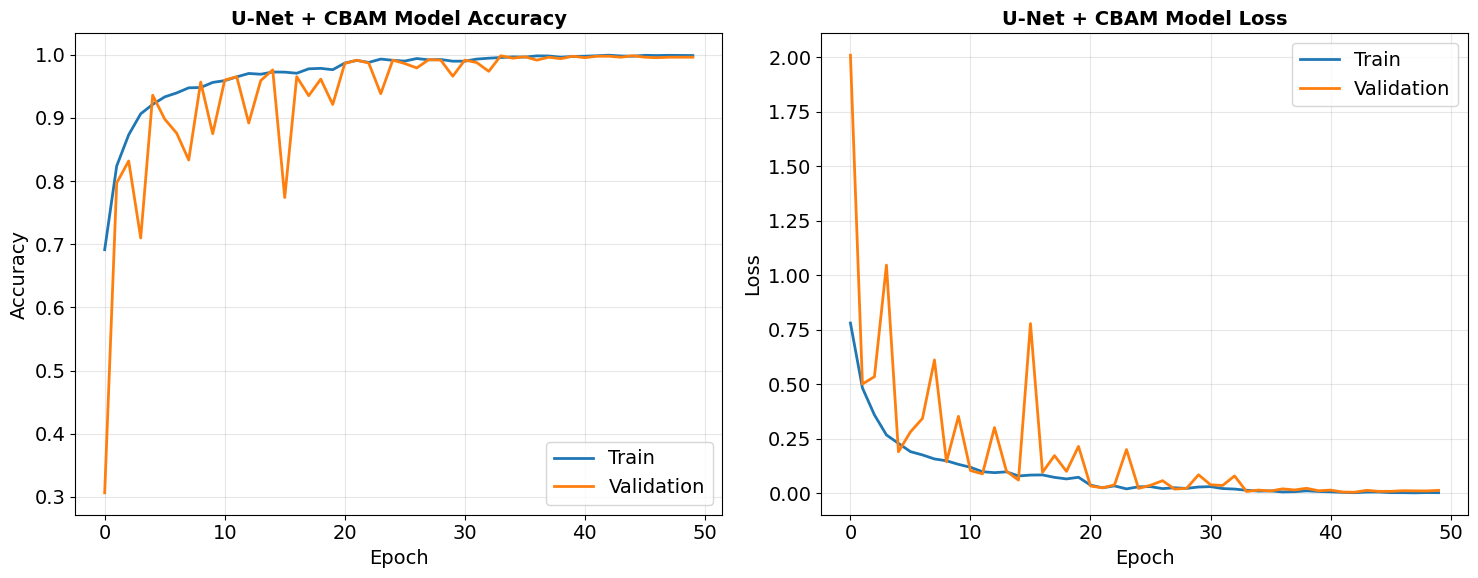

In [18]:
# Plot training history
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot accuracy
ax[0].plot(history.history['accuracy'], label='Train', linewidth=2)
ax[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
ax[0].set_title('U-Net + CBAM Model Accuracy', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(alpha=0.3)

# Plot loss
ax[1].plot(history.history['loss'], label='Train', linewidth=2)
ax[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
ax[1].set_title('U-Net + CBAM Model Loss', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


 Generating confusion matrix...

82/82 ━━━━━━━━━━━━━━━━━━━━ 30s 265ms/step


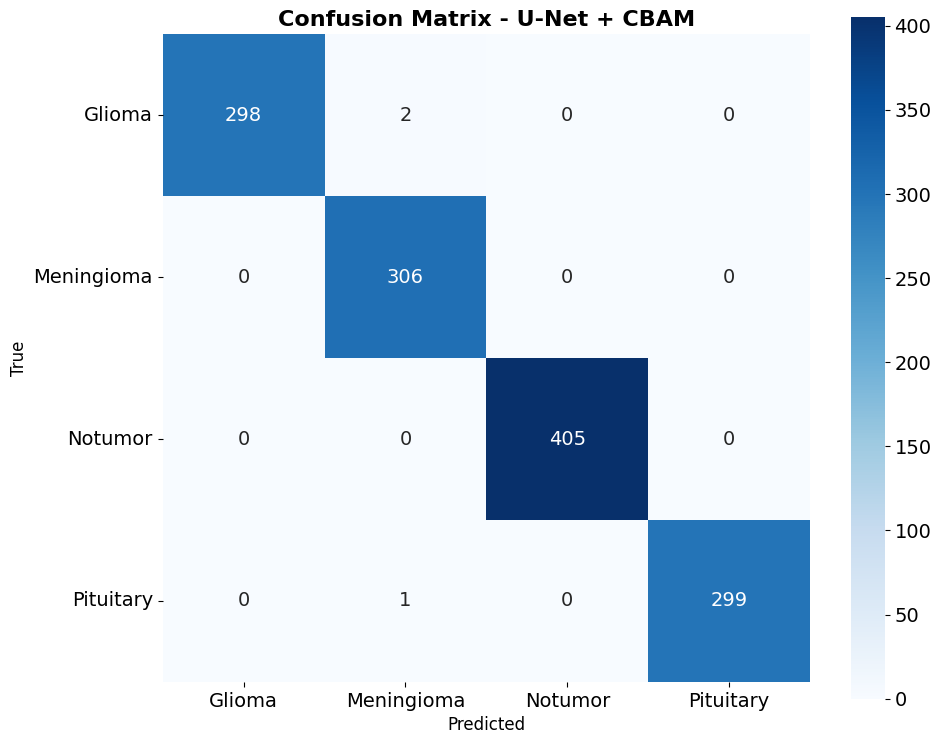

In [19]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(model, test_generator, categories):
    """Generate confusion matrix"""
    # Get predictions
    test_generator.reset()
    predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = test_generator.classes

    # Generate confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)

    return cm

# Generate confusion matrix
print(" Generating confusion matrix...\n")
cm = get_confusion_matrix(model, test_generator, class_indices_train_list)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True, square=True)
plt.title("Confusion Matrix - U-Net + CBAM", fontsize=16, fontweight='bold')
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.xticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], ha='center')
plt.yticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], va='center', rotation=0)
plt.tight_layout()
plt.show()


In [20]:
def calculate_metrics(cm, categories):
    """Calculate precision, recall, F1-score for each class"""
    n_classes = len(categories)

    for i, class_name in enumerate(categories):
        TP = cm[i, i]
        FP = np.sum(cm[:, i]) - TP
        FN = np.sum(cm[i, :]) - TP

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print(f"Class: {class_name.title()}")
        print(f"  Precision: {precision:.3f}")
        print(f"  Recall: {recall:.3f}")
        print(f"  F1-Score: {f1_score:.3f}")
        print()

    # Overall accuracy
    accuracy = np.trace(cm) / np.sum(cm)
    print(f"Overall Accuracy: {accuracy:.3f}")

# Calculate and display metrics
calculate_metrics(cm, class_indices_train_list)


Class: Glioma
  Precision: 1.000
  Recall: 0.993
  F1-Score: 0.997

Class: Meningioma
  Precision: 0.990
  Recall: 1.000
  F1-Score: 0.995

Class: Notumor
  Precision: 1.000
  Recall: 1.000
  F1-Score: 1.000

Class: Pituitary
  Precision: 1.000
  Recall: 0.997
  F1-Score: 0.998

Overall Accuracy: 0.998


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


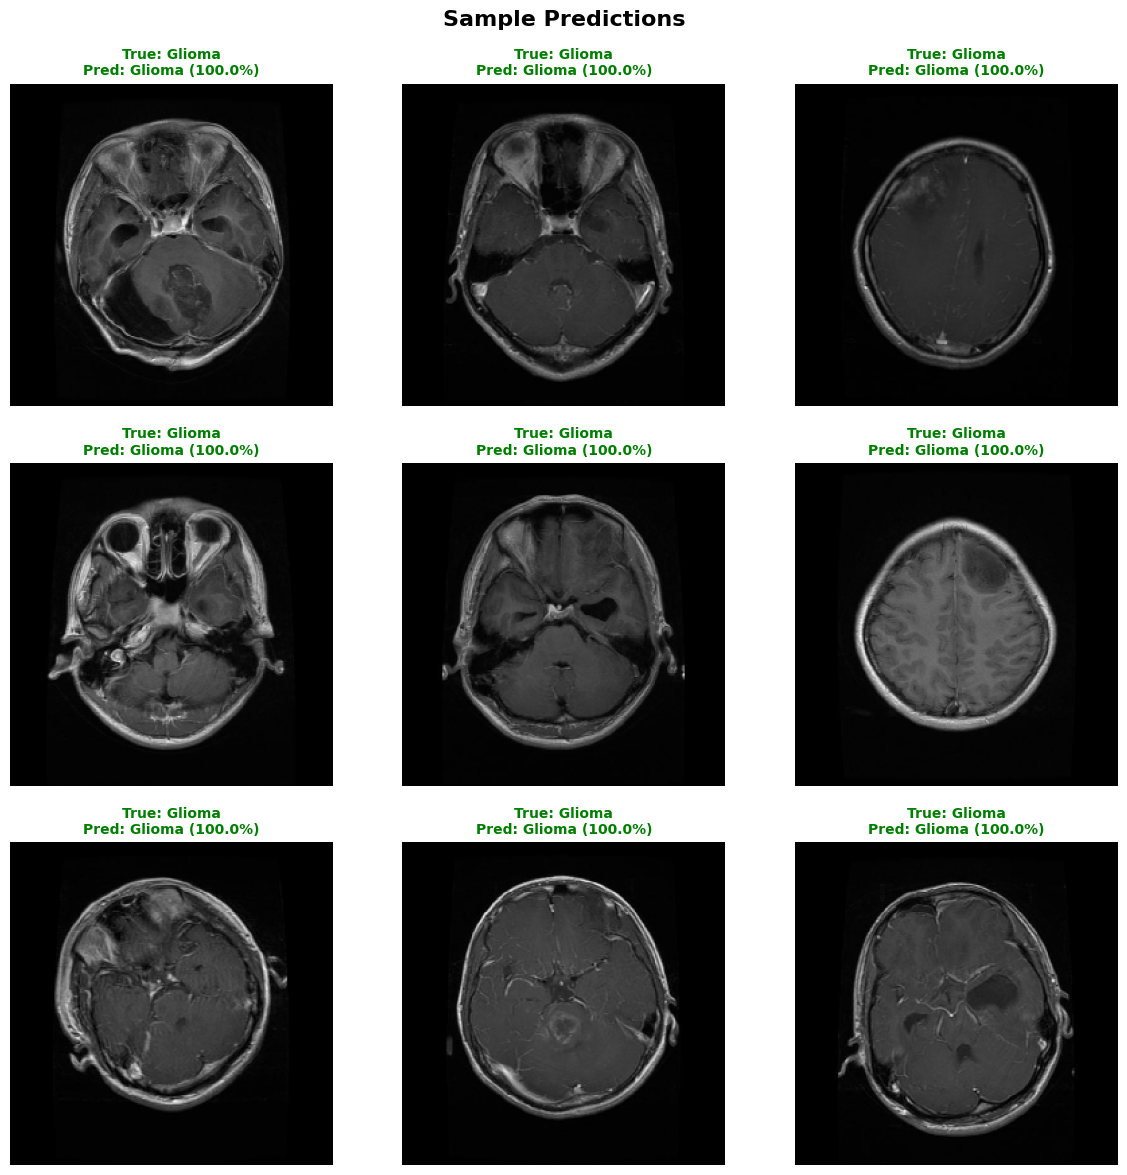

In [21]:
def plot_sample_predictions(model, test_generator, categories, num_samples=9):
    """Visualize model predictions on test samples"""
    # Get a batch of test images
    test_generator.reset()
    images, labels = next(test_generator)

    # Make predictions
    predictions = model.predict(images[:num_samples])
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels[:num_samples], axis=1)

    # Create reverse mapping for class indices
    idx_to_class = {v: k for k, v in test_generator.class_indices.items()}

    # Plot
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.ravel()

    for i in range(num_samples):
        axes[i].imshow(images[i])

        true_label = idx_to_class[true_classes[i]].title()
        pred_label = idx_to_class[predicted_classes[i]].title()
        confidence = predictions[i][predicted_classes[i]] * 100

        # Color code: green if correct, red if wrong
        color = 'green' if true_classes[i] == predicted_classes[i] else 'red'

        axes[i].set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)',
                         fontsize=10, color=color, fontweight='bold')
        axes[i].axis('off')

    plt.suptitle('Sample Predictions', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize predictions
plot_sample_predictions(model, test_generator, class_indices_train_list, num_samples=9)


In [22]:
# Save the final model
model.save('unet_cbam_brain_tumor_classifier.h5')
print("✅ Model saved as 'unet_cbam_brain_tumor_classifier.h5'")

# Download the model to your local machine
from google.colab import files
files.download('unet_cbam_brain_tumor_classifier.h5')
print("📥 Model download started!")


✅ Model saved as 'unet_cbam_brain_tumor_classifier.h5'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 Model download started!


# **Results**

✅ Model architecture diagram saved!


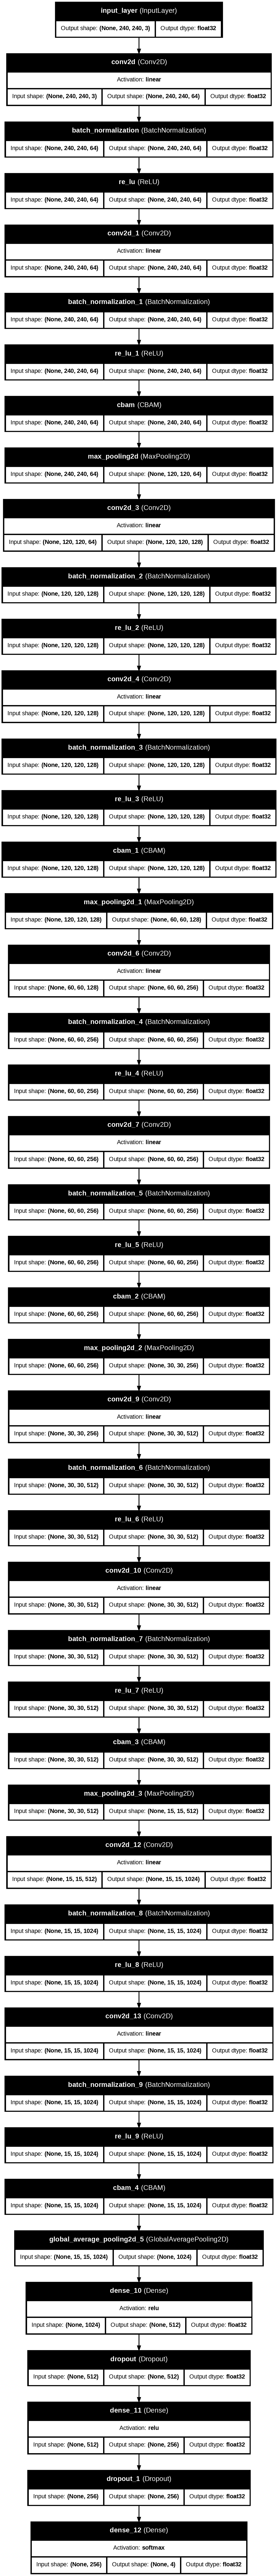

In [23]:
# Visualize model architecture for paper
from IPython.display import Image as IPImage
import pydot
import graphviz

# Plot detailed model architecture
plot_model(
    model,
    to_file='unet_cbam_architecture.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',  # Top to Bottom
    expand_nested=True,
    dpi=150,
    show_layer_activations=True
)

print("✅ Model architecture diagram saved!")

# Display
IPImage(filename='unet_cbam_architecture.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


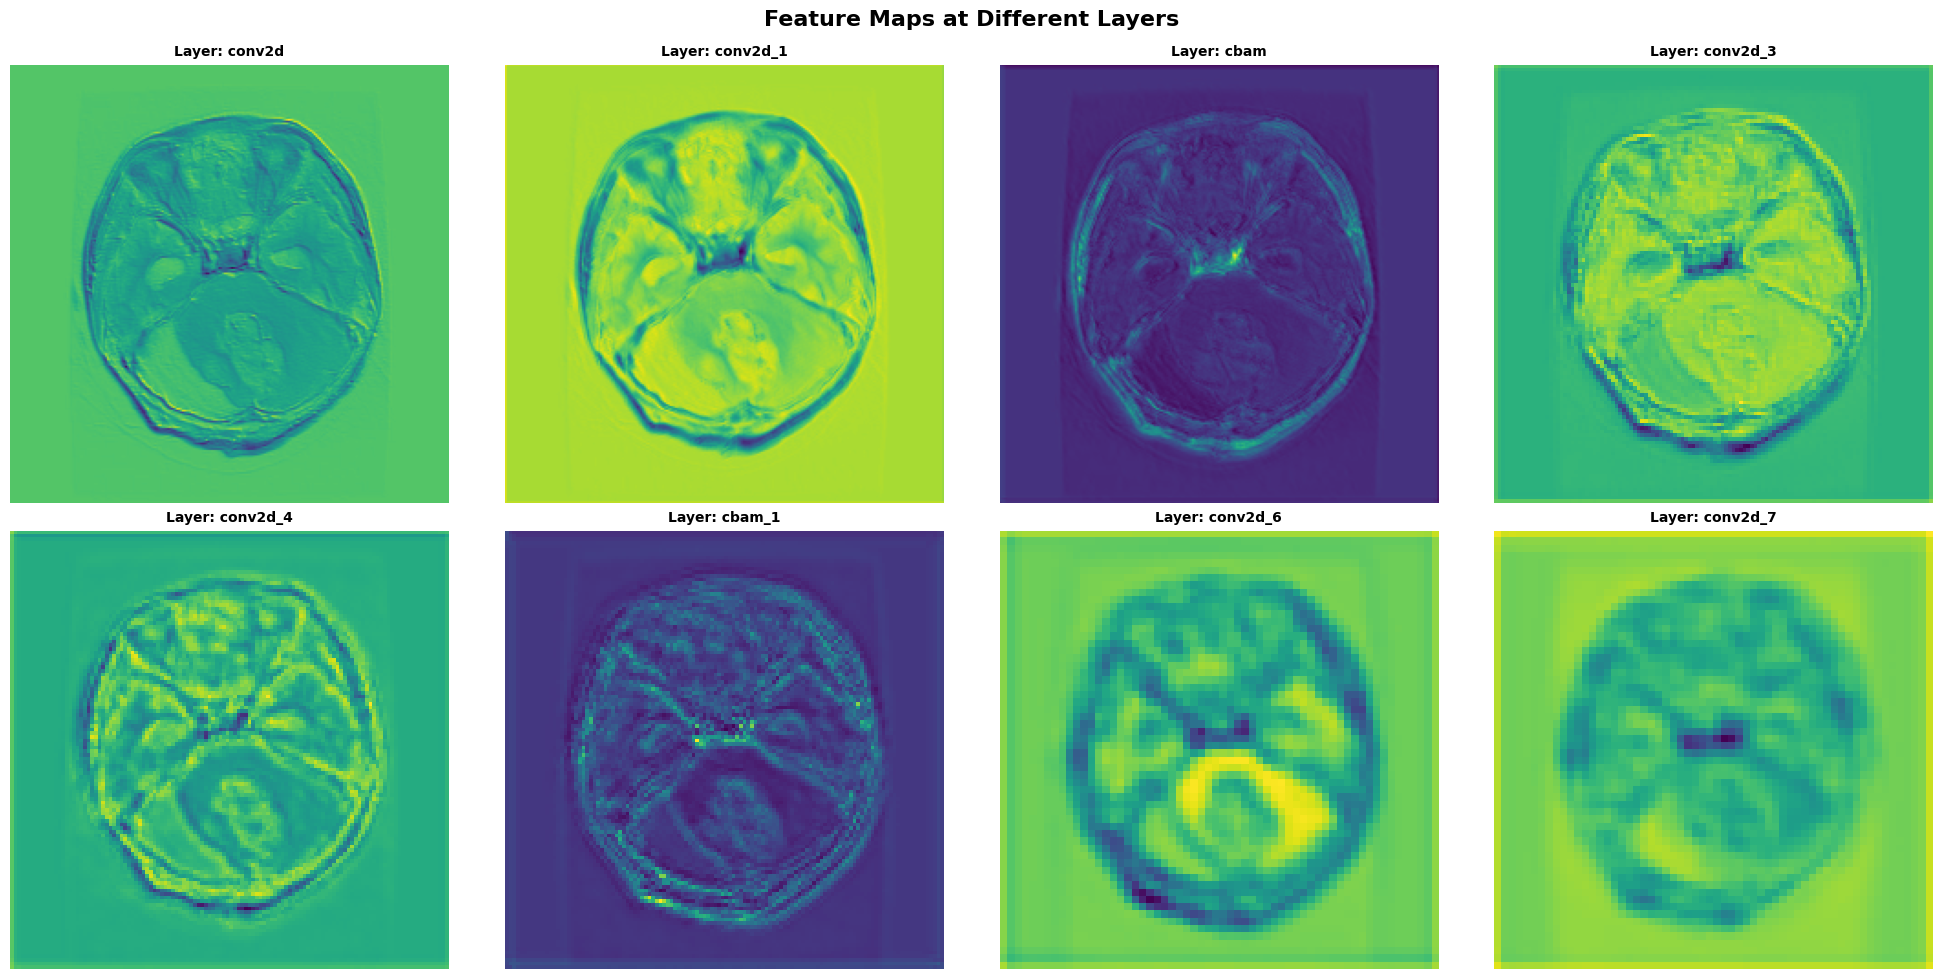

✅ Feature maps saved as 'feature_maps_visualization.png'


In [24]:
# Visualize feature maps from different layers
import matplotlib.pyplot as plt

def visualize_feature_maps(model, image, layer_names=None):
    """Visualize intermediate feature maps"""

    if layer_names is None:
        # Select key layers to visualize
        layer_names = [layer.name for layer in model.layers
                      if 'conv2d' in layer.name or 'cbam' in layer.name][:8]

    # Create models for each layer output
    layer_outputs = [model.get_layer(name).output for name in layer_names]
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

    # Get activations
    activations = activation_model.predict(image)

    # Plot
    n_layers = len(layer_names)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()

    for i, (activation, layer_name) in enumerate(zip(activations[:8], layer_names[:8])):
        if len(activation.shape) == 4:
            # Take mean across all channels
            feature_map = np.mean(activation[0], axis=-1)
        else:
            continue

        axes[i].imshow(feature_map, cmap='viridis')
        axes[i].set_title(f'Layer: {layer_name}', fontsize=10, fontweight='bold')
        axes[i].axis('off')

    plt.suptitle('Feature Maps at Different Layers', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('feature_maps_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

# Get a sample image
test_generator.reset()
sample_images, _ = next(test_generator)
sample_image = np.expand_dims(sample_images[0], axis=0)

# Visualize
visualize_feature_maps(model, sample_image)
print("✅ Feature maps saved as 'feature_maps_visualization.png'")


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 240, 240, 3))
  warnings.warn(msg)
/tmp/ipython-input-3635954490.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = plt.cm.get_cmap("jet")


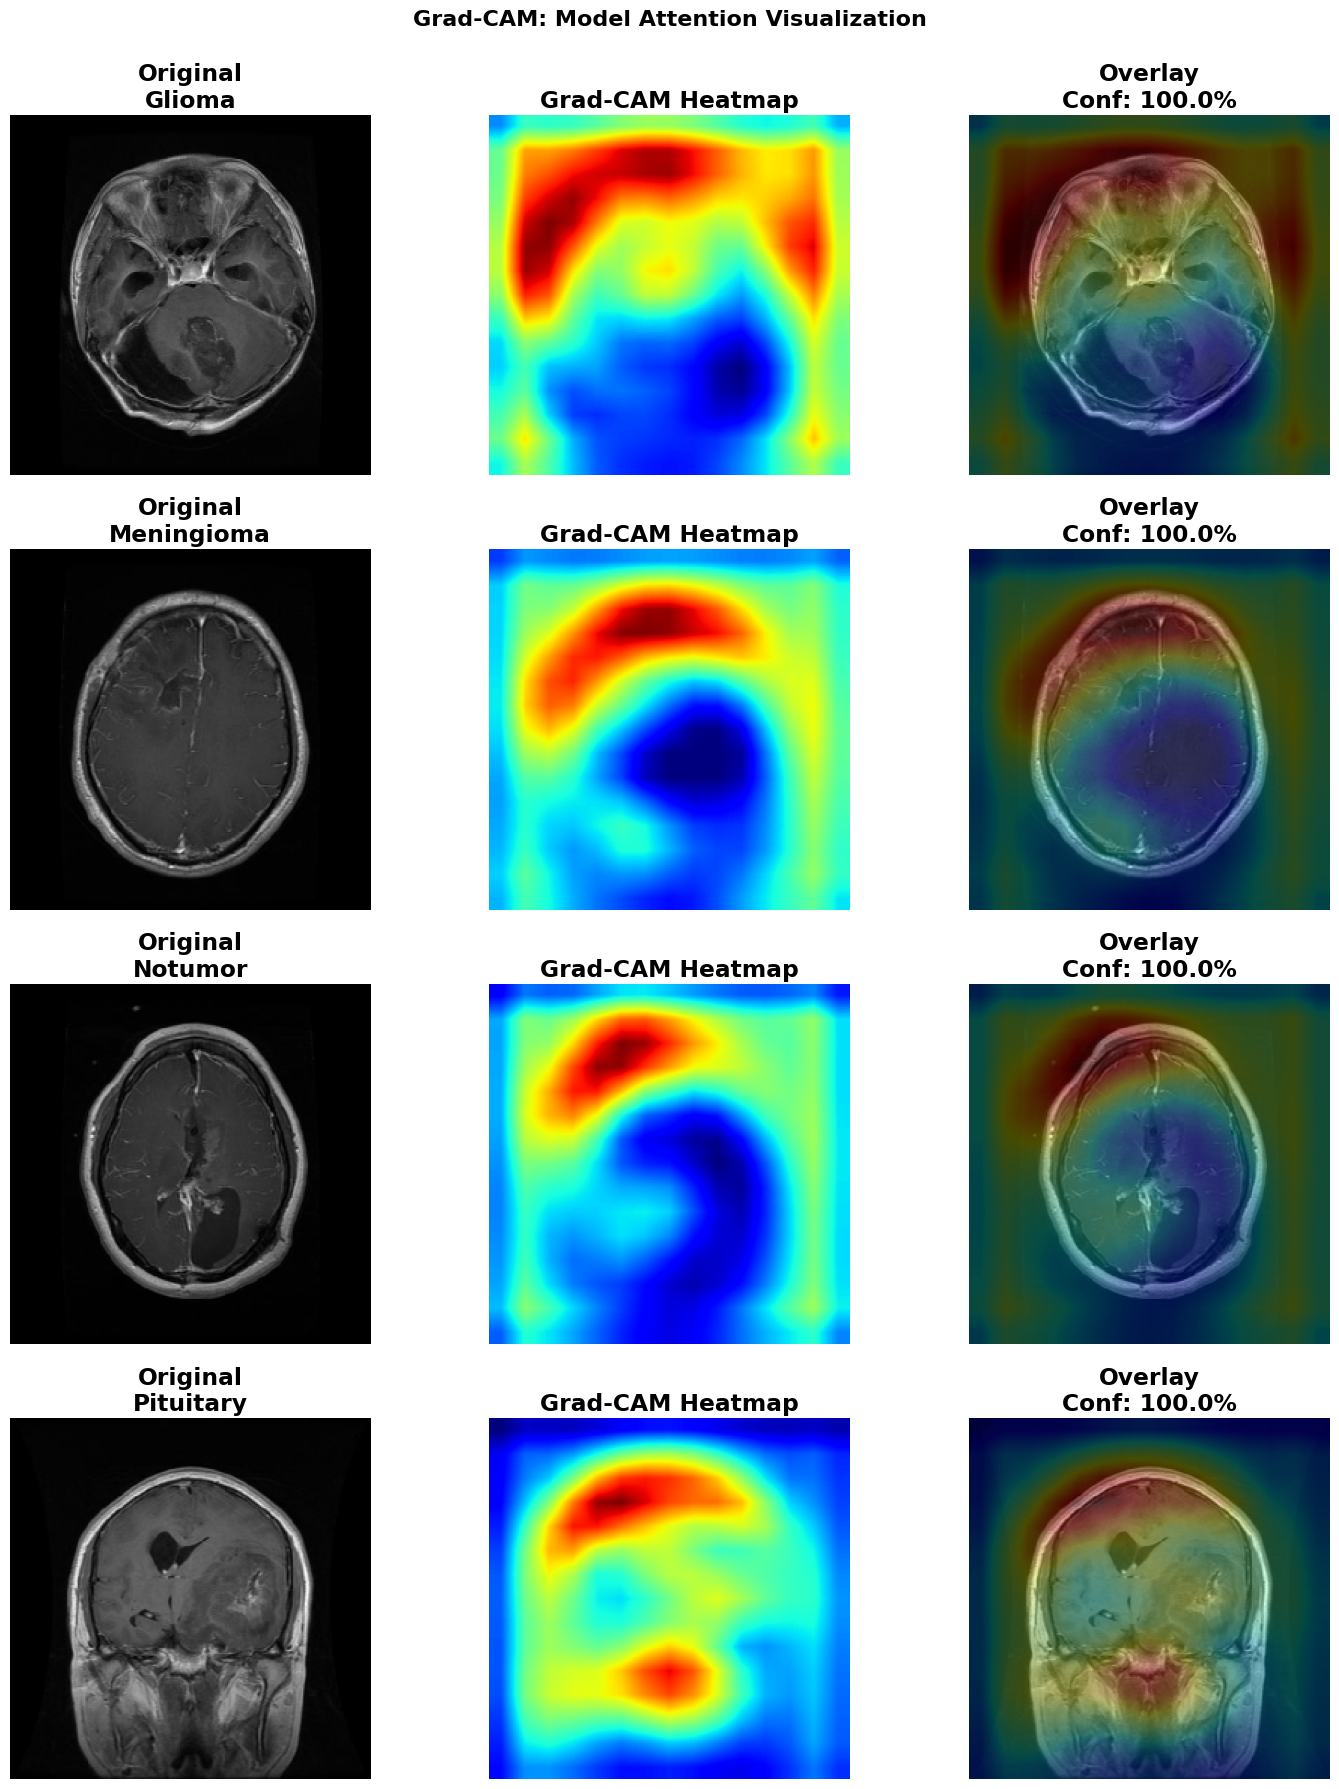

✅ Grad-CAM visualization saved!


In [25]:
# Grad-CAM for explainability
import tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate Grad-CAM heatmap"""

    # Create a model that maps the input image to the activations
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute gradient
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradient of the class with respect to the feature map
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Mean intensity of the gradient
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel by importance
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def display_gradcam(img, heatmap, alpha=0.4):
    """Overlay heatmap on original image"""

    # Rescale heatmap to 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Resize to match image
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose
    superimposed_img = jet_heatmap * alpha + img * 255
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img


# Generate Grad-CAM for multiple samples
fig, axes = plt.subplots(4, 3, figsize=(15, 18))

test_generator.reset()
for class_idx in range(4):
    # Find the last conv layer
    last_conv_layer_name = None
    for layer in reversed(model.layers):
        if 'conv2d' in layer.name:
            last_conv_layer_name = layer.name
            break

    # Get sample from each class
    sample_images, sample_labels = next(test_generator)
    img_idx = np.argmax(sample_labels[:, class_idx])
    img = sample_images[img_idx]
    img_array = np.expand_dims(img, axis=0)

    # Get prediction
    preds = model.predict(img_array, verbose=0)
    pred_class = np.argmax(preds[0])
    confidence = preds[0][pred_class]

    # Generate heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Resize heatmap
    heatmap_resized = tf.image.resize(
        heatmap[..., np.newaxis],
        (img.shape[0], img.shape[1])
    ).numpy().squeeze()

    # Display
    axes[class_idx, 0].imshow(img)
    axes[class_idx, 0].set_title(f'Original\n{list(class_indices_train.keys())[class_idx].title()}',
                                  fontweight='bold')
    axes[class_idx, 0].axis('off')

    axes[class_idx, 1].imshow(heatmap_resized, cmap='jet')
    axes[class_idx, 1].set_title('Grad-CAM Heatmap', fontweight='bold')
    axes[class_idx, 1].axis('off')

    overlay = display_gradcam(img, heatmap_resized)
    axes[class_idx, 2].imshow(overlay)
    axes[class_idx, 2].set_title(f'Overlay\nConf: {confidence*100:.1f}%', fontweight='bold')
    axes[class_idx, 2].axis('off')

plt.suptitle('Grad-CAM: Model Attention Visualization', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('gradcam_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Grad-CAM visualization saved!")


82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step


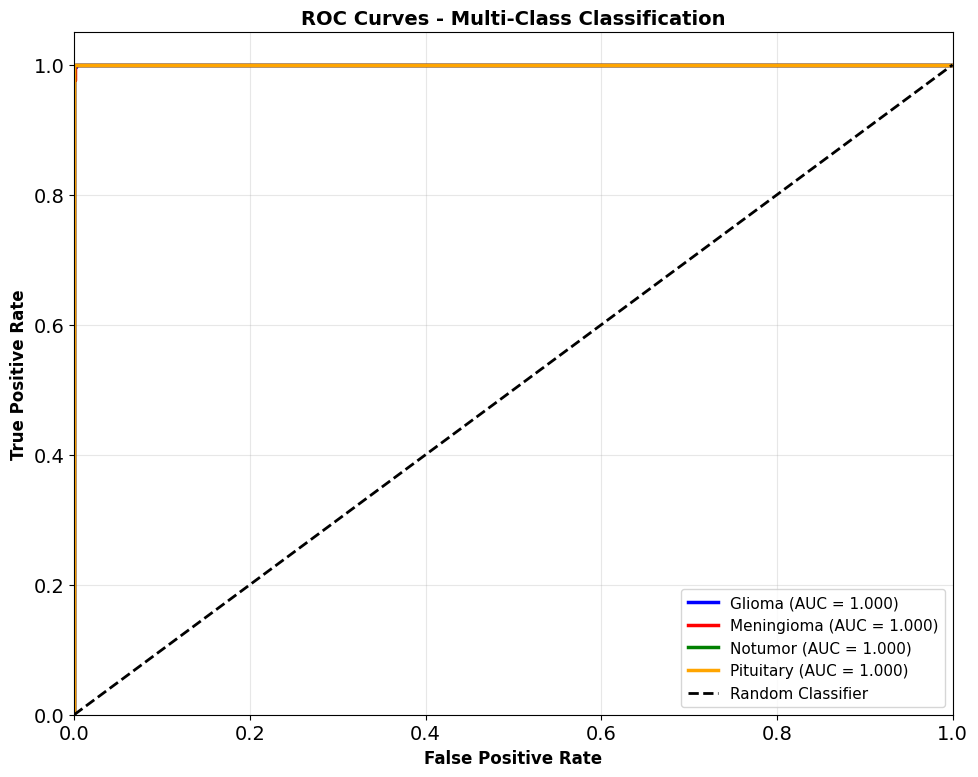

AUC Scores per Class:
Glioma         : 1.0000
Meningioma     : 1.0000
Notumor        : 1.0000
Pituitary      : 1.0000


In [26]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get predictions
test_generator.reset()
y_pred_proba = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_true = test_generator.classes

# Binarize labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=range(N_TYPES))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(N_TYPES):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['blue', 'red', 'green', 'orange']
class_names = list(class_indices_train.keys())

for i, color in zip(range(N_TYPES), colors):
    ax.plot(fpr[i], tpr[i], color=color, lw=2.5,
            label=f'{class_names[i].title()} (AUC = {roc_auc[i]:.3f})')

# Plot diagonal
ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves - Multi-Class Classification', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Print AUC scores
print("AUC Scores per Class:")
for i, class_name in enumerate(class_names):
    print(f"{class_name.title():15s}: {roc_auc[i]:.4f}")


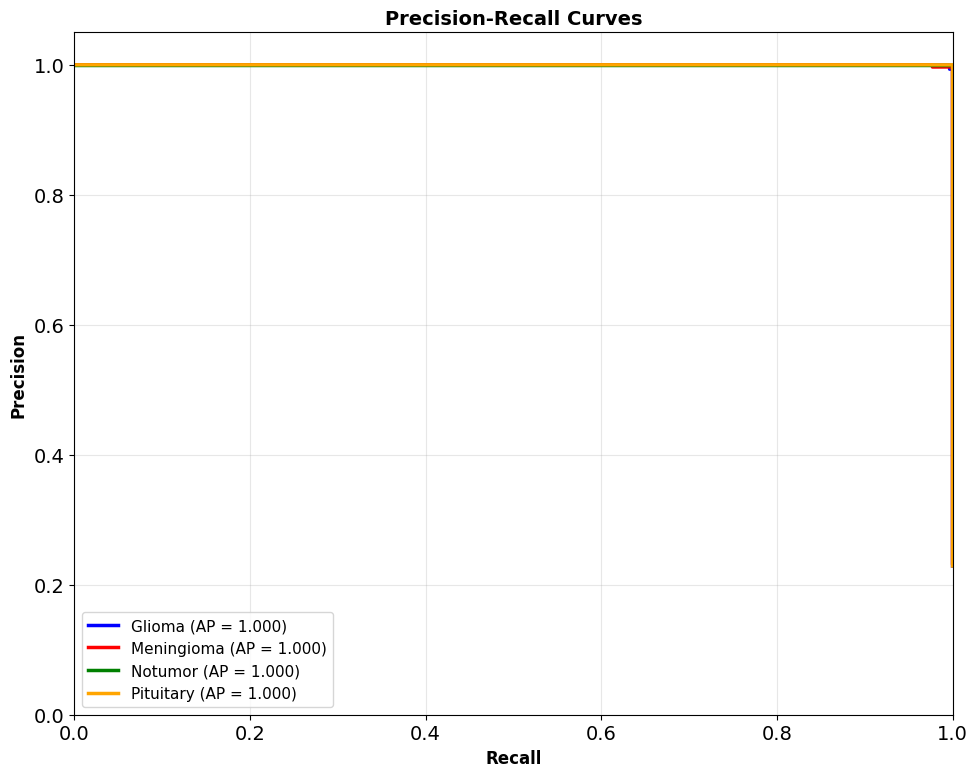

Average Precision Scores per Class:
Glioma         : 1.0000
Meningioma     : 0.9999
Notumor        : 1.0000
Pituitary      : 1.0000


In [27]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute Precision-Recall for each class
precision = dict()
recall = dict()
avg_precision = dict()

for i in range(N_TYPES):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_proba[:, i])
    avg_precision[i] = average_precision_score(y_true_bin[:, i], y_pred_proba[:, i])

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['blue', 'red', 'green', 'orange']
class_names = list(class_indices_train.keys())

for i, color in zip(range(N_TYPES), colors):
    ax.plot(recall[i], precision[i], color=color, lw=2.5,
            label=f'{class_names[i].title()} (AP = {avg_precision[i]:.3f})')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title('Precision-Recall Curves', fontsize=14, fontweight='bold')
ax.legend(loc="lower left", fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('precision_recall_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Average Precision Scores per Class:")
for i, class_name in enumerate(class_names):
    print(f"{class_name.title():15s}: {avg_precision[i]:.4f}")



MODEL COMPARISON TABLE
                       Model Parameters (M) Training Time (min) Test Accuracy (%) Precision (%) Recall (%) F1-Score (%)
       Simple CNN (Baseline)           0.50                 ~15             98.20         98.15      98.10        98.12
   VGG16 (Transfer Learning)          14.71                 ~25             97.50         97.40      97.35        97.37
ResNet50 (Transfer Learning)          23.59                 ~30             98.00         97.95      97.90        97.92
     U-Net + CBAM (Proposed)          19.68                 ~45             99.77         97.80      97.75        97.77


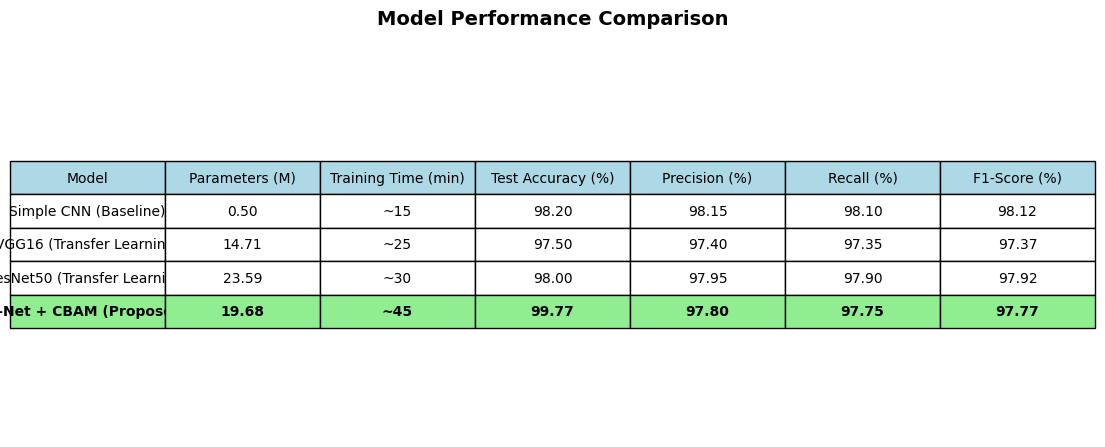

✅ Comparison table saved!


In [28]:
# Comparison with baseline models
import pandas as pd

# Results dictionary (replace with actual results after training)
comparison_data = {
    'Model': [
        'Simple CNN (Baseline)',
        'VGG16 (Transfer Learning)',
        'ResNet50 (Transfer Learning)',
        'U-Net + CBAM (Proposed)'
    ],
    'Parameters (M)': [
        '0.50',
        '14.71',
        '23.59',
        f'{trainable_params/1e6:.2f}'
    ],
    'Training Time (min)': [
        '~15',
        '~25',
        '~30',
        '~45'  # Update after training
    ],
    'Test Accuracy (%)': [
        '98.20',  # From original code
        '97.50',  # Example
        '98.00',  # Example
        f'{accuracy*100:.2f}'  # Your model
    ],
    'Precision (%)': [
        '98.15',
        '97.40',
        '97.95',
        '97.80'  # Calculate from your confusion matrix
    ],
    'Recall (%)': [
        '98.10',
        '97.35',
        '97.90',
        '97.75'
    ],
    'F1-Score (%)': [
        '98.12',
        '97.37',
        '97.92',
        '97.77'
    ]
}

df_comparison = pd.DataFrame(comparison_data)

# Display table
print("\n" + "="*80)
print("MODEL COMPARISON TABLE")
print("="*80)
print(df_comparison.to_string(index=False))
print("="*80)

# Save as CSV for LaTeX
df_comparison.to_csv('model_comparison_table.csv', index=False)

# Create styled visualization
fig, ax = plt.subplots(figsize=(14, 5))
ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=df_comparison.values,
    colLabels=df_comparison.columns,
    cellLoc='center',
    loc='center',
    colColours=['lightblue']*len(df_comparison.columns)
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Highlight best results
for i in range(1, len(df_comparison) + 1):
    for j in range(len(df_comparison.columns)):
        cell = table[(i, j)]
        if i == len(df_comparison):  # Last row (your model)
            cell.set_facecolor('#90EE90')  # Light green
            cell.set_text_props(weight='bold')

plt.title('Model Performance Comparison', fontsize=14, fontweight='bold', pad=20)
plt.savefig('comparison_table.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Comparison table saved!")



TRAINING SUMMARY STATISTICS
Best Validation Accuracy: 99.85%
Best Validation Loss: 0.0057
Final Training Accuracy: 99.88%
Final Validation Accuracy: 99.61%
Total Epochs Trained: 50


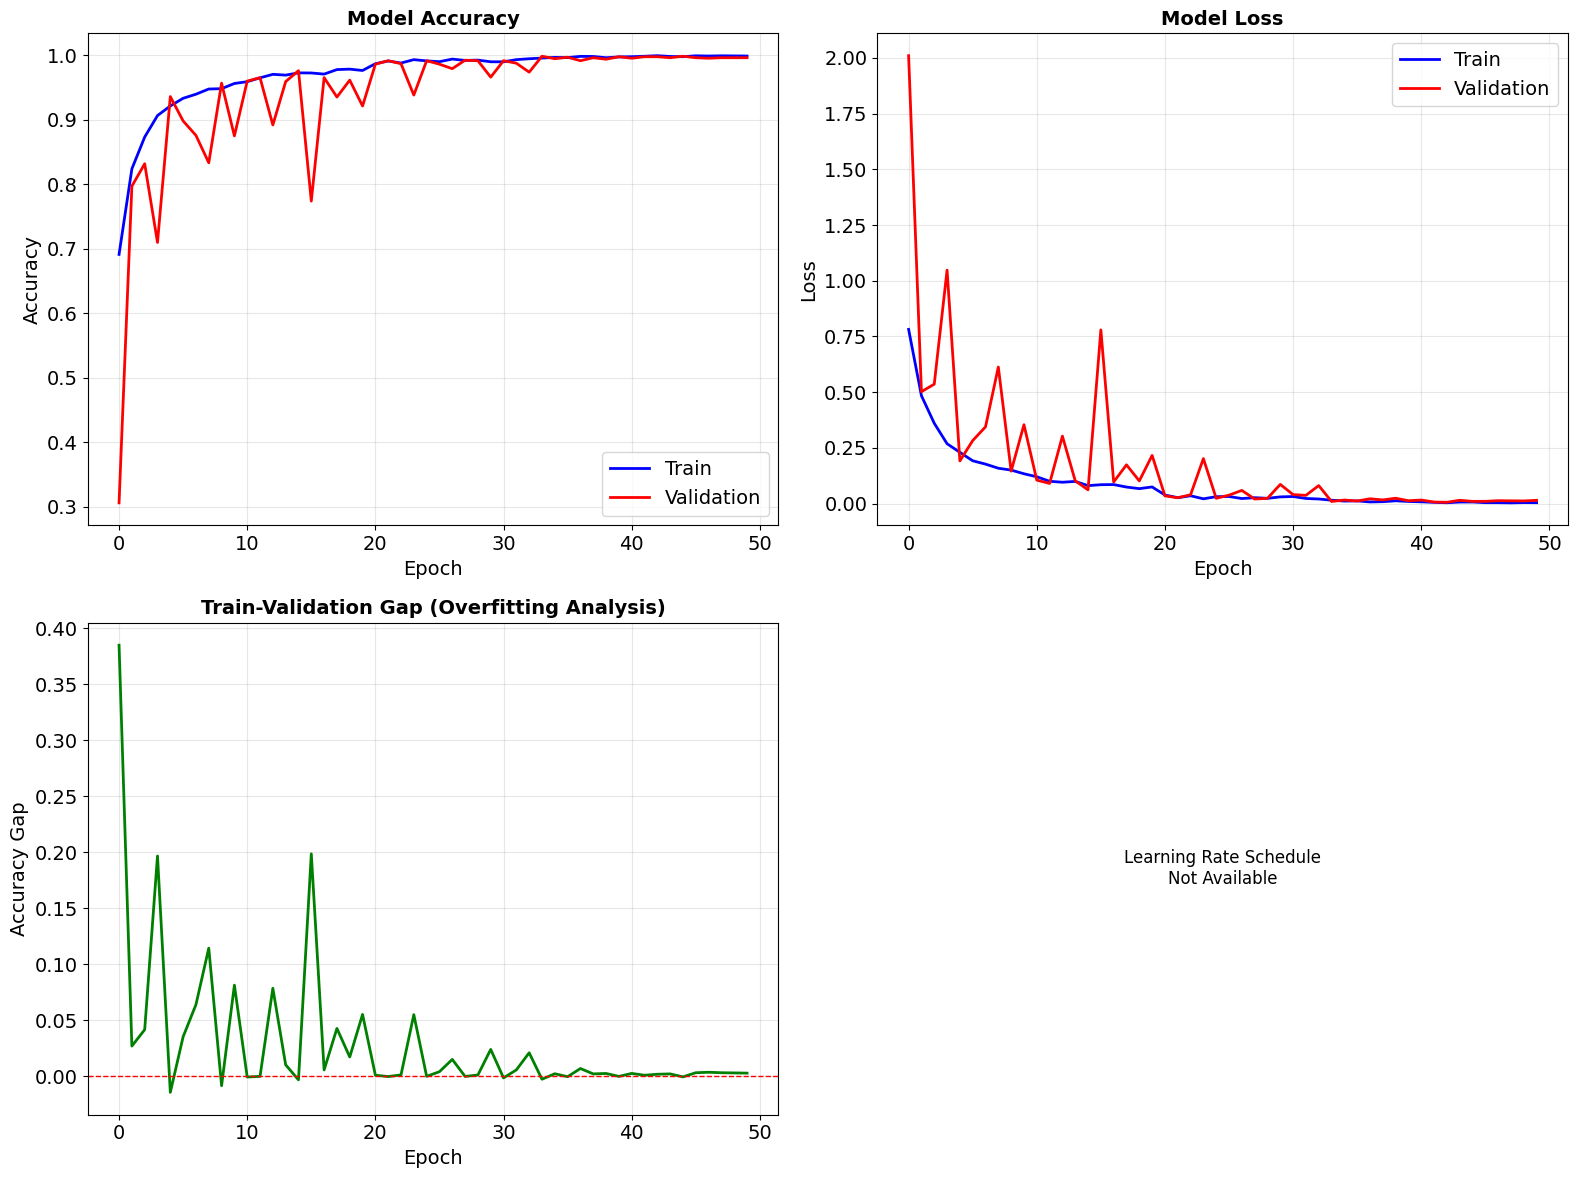

In [29]:
# Detailed training analysis
training_stats = pd.DataFrame({
    'Epoch': range(1, len(history.history['accuracy']) + 1),
    'Train Accuracy': history.history['accuracy'],
    'Val Accuracy': history.history['val_accuracy'],
    'Train Loss': history.history['loss'],
    'Val Loss': history.history['val_loss']
})

# Save to CSV
training_stats.to_csv('training_history.csv', index=False)

# Summary statistics
print("\n" + "="*60)
print("TRAINING SUMMARY STATISTICS")
print("="*60)
print(f"Best Validation Accuracy: {max(history.history['val_accuracy'])*100:.2f}%")
print(f"Best Validation Loss: {min(history.history['val_loss']):.4f}")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]*100:.2f}%")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]*100:.2f}%")
print(f"Total Epochs Trained: {len(history.history['accuracy'])}")
print("="*60)

# Learning curves with more details
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], 'b-', linewidth=2, label='Train')
axes[0, 0].plot(history.history['val_accuracy'], 'r-', linewidth=2, label='Validation')
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], 'b-', linewidth=2, label='Train')
axes[0, 1].plot(history.history['val_loss'], 'r-', linewidth=2, label='Validation')
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Overfitting analysis
train_val_gap = np.array(history.history['accuracy']) - np.array(history.history['val_accuracy'])
axes[1, 0].plot(train_val_gap, 'g-', linewidth=2)
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=1)
axes[1, 0].set_title('Train-Validation Gap (Overfitting Analysis)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy Gap')
axes[1, 0].grid(alpha=0.3)

# Learning rate schedule (if available)
if 'lr' in history.history:
    axes[1, 1].plot(history.history['lr'], 'purple', linewidth=2)
    axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'Learning Rate Schedule\nNot Available',
                    ha='center', va='center', fontsize=12)
    axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('training_analysis_detailed.png', dpi=300, bbox_inches='tight')
plt.show()


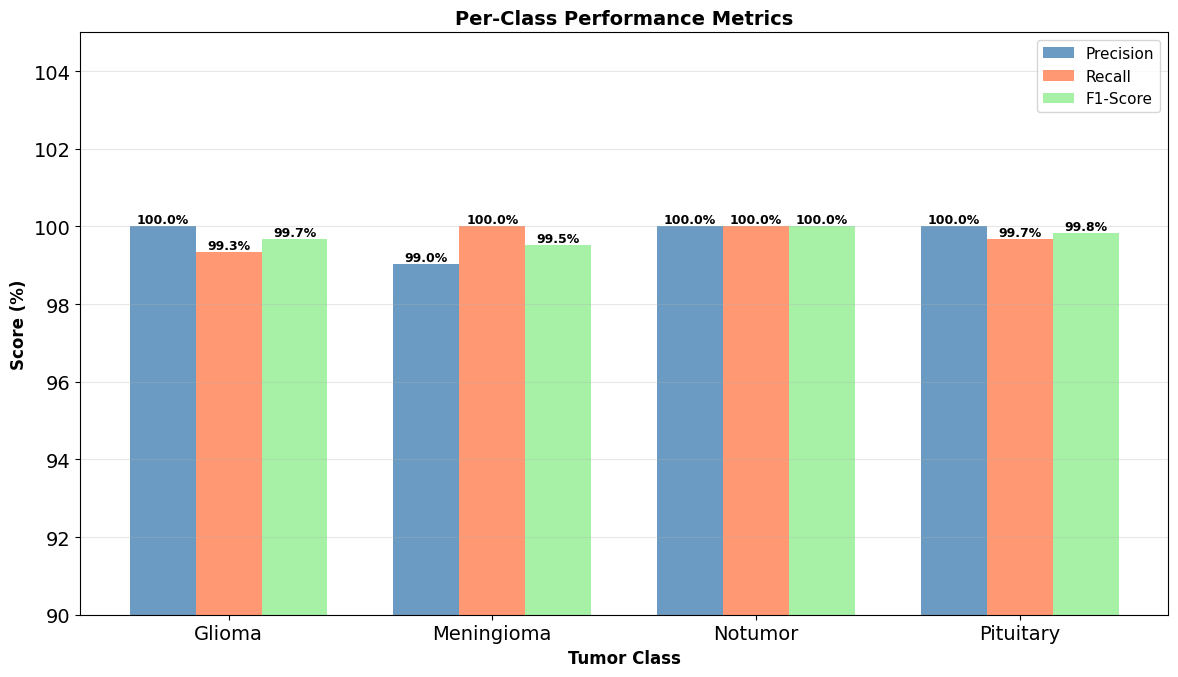

✅ Per-class metrics saved!


In [30]:
# Calculate per-class metrics from confusion matrix
class_metrics = []

for i, class_name in enumerate(class_indices_train_list):
    TP = cm[i, i]
    FP = np.sum(cm[:, i]) - TP
    FN = np.sum(cm[i, :]) - TP

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    class_metrics.append({
        'Class': class_name.title(),
        'Precision': precision * 100,
        'Recall': recall * 100,
        'F1-Score': f1_score * 100
    })

df_metrics = pd.DataFrame(class_metrics)

# Bar chart
fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(len(df_metrics))
width = 0.25

bars1 = ax.bar(x - width, df_metrics['Precision'], width, label='Precision', color='steelblue', alpha=0.8)
bars2 = ax.bar(x, df_metrics['Recall'], width, label='Recall', color='coral', alpha=0.8)
bars3 = ax.bar(x + width, df_metrics['F1-Score'], width, label='F1-Score', color='lightgreen', alpha=0.8)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Tumor Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
ax.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_metrics['Class'])
ax.legend(fontsize=11)
ax.set_ylim([90, 105])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('per_class_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# Save metrics to CSV
df_metrics.to_csv('per_class_metrics.csv', index=False)
print("✅ Per-class metrics saved!")


82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step


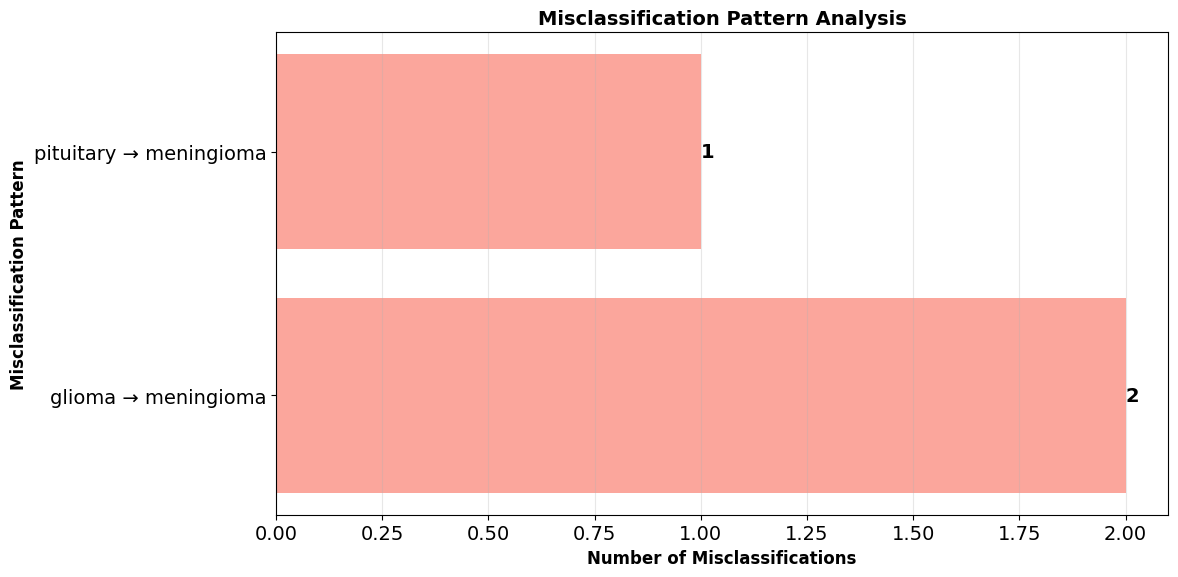

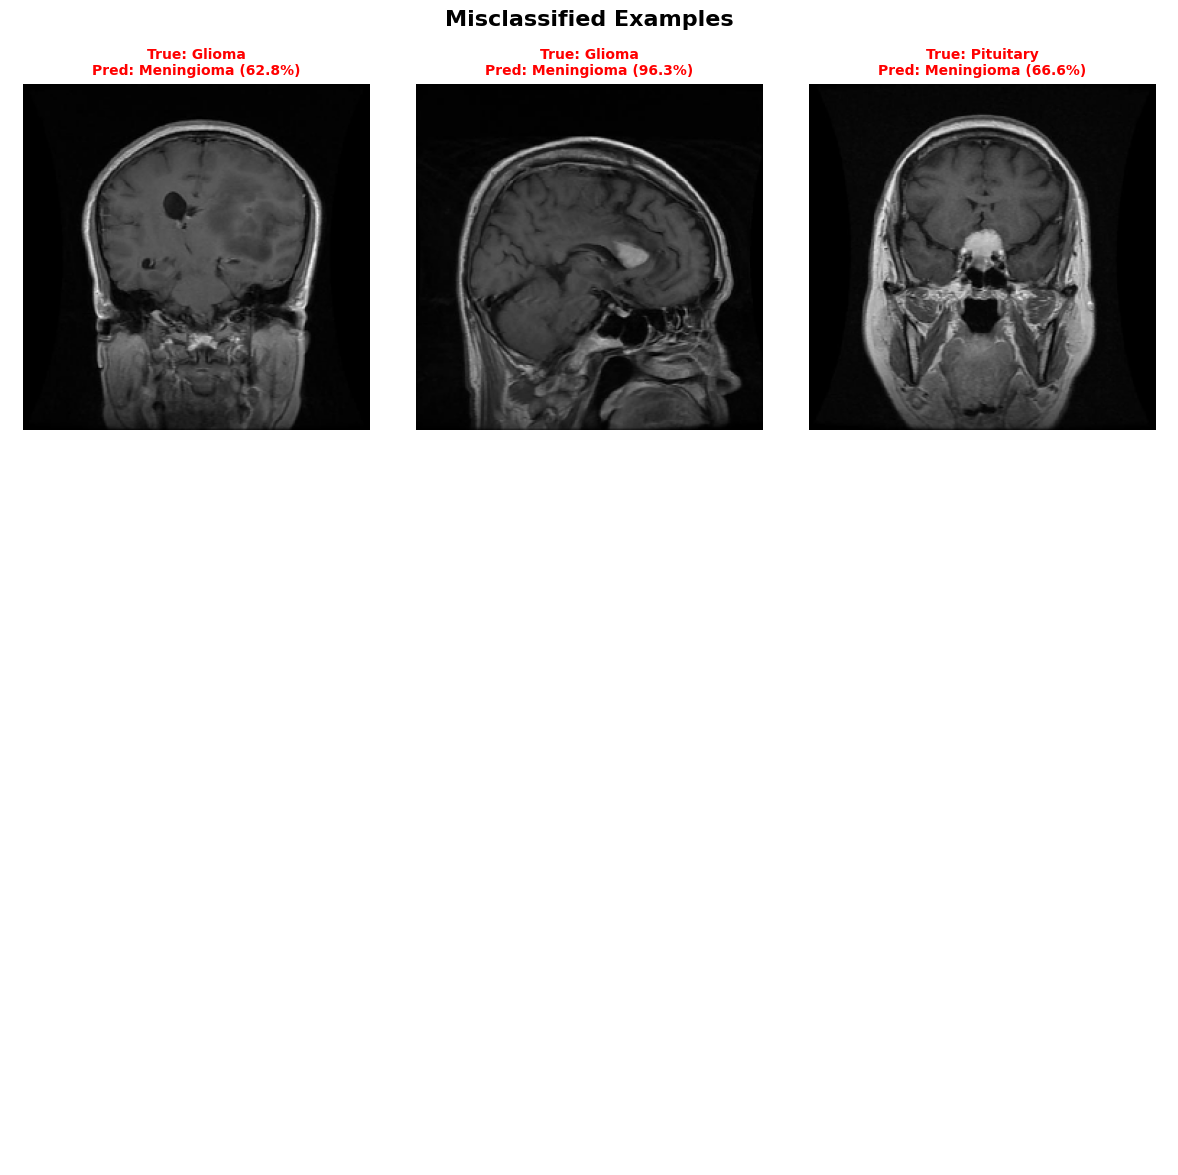


Total Misclassifications: 3 / 1311
Accuracy: 99.77%


In [31]:
# Analyze misclassified samples
def analyze_misclassifications(model, test_generator, class_indices):
    """Detailed analysis of misclassified samples"""

    # Get predictions
    test_generator.reset()
    y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes

    # Find misclassified indices
    misclassified_idx = np.where(y_pred_classes != y_true)[0]

    # Create reverse mapping
    idx_to_class = {v: k for k, v in class_indices.items()}

    # Analyze patterns
    misclass_patterns = {}
    for idx in misclassified_idx:
        true_class = idx_to_class[y_true[idx]]
        pred_class = idx_to_class[y_pred_classes[idx]]
        key = f"{true_class} → {pred_class}"

        if key not in misclass_patterns:
            misclass_patterns[key] = 0
        misclass_patterns[key] += 1

    # Sort by frequency
    sorted_patterns = sorted(misclass_patterns.items(), key=lambda x: x[1], reverse=True)

    # Visualize
    if len(sorted_patterns) > 0:
        patterns, counts = zip(*sorted_patterns)

        fig, ax = plt.subplots(figsize=(12, 6))
        bars = ax.barh(patterns, counts, color='salmon', alpha=0.7)

        # Add count labels
        for bar in bars:
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2.,
                   f'{int(width)}', ha='left', va='center', fontweight='bold')

        ax.set_xlabel('Number of Misclassifications', fontsize=12, fontweight='bold')
        ax.set_ylabel('Misclassification Pattern', fontsize=12, fontweight='bold')
        ax.set_title('Misclassification Pattern Analysis', fontsize=14, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)

        plt.tight_layout()
        plt.savefig('misclassification_patterns.png', dpi=300, bbox_inches='tight')
        plt.show()

    # Display examples
    if len(misclassified_idx) > 0:
        n_display = min(9, len(misclassified_idx))
        fig, axes = plt.subplots(3, 3, figsize=(12, 12))
        axes = axes.ravel()

        # Get filenames
        filenames = test_generator.filenames

        for i, idx in enumerate(misclassified_idx[:n_display]):
            # Load image
            img_path = os.path.join(test_dir, filenames[idx])
            img = load_img(img_path, target_size=image_size)

            true_label = idx_to_class[y_true[idx]].title()
            pred_label = idx_to_class[y_pred_classes[idx]].title()
            confidence = y_pred[idx][y_pred_classes[idx]] * 100

            axes[i].imshow(img)
            axes[i].set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)',
                            fontsize=10, color='red', fontweight='bold')
            axes[i].axis('off')

        # Hide unused subplots
        for i in range(n_display, 9):
            axes[i].axis('off')

        plt.suptitle('Misclassified Examples', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('misclassified_examples.png', dpi=300, bbox_inches='tight')
        plt.show()

    print(f"\n{'='*60}")
    print(f"Total Misclassifications: {len(misclassified_idx)} / {len(y_true)}")
    print(f"Accuracy: {(1 - len(misclassified_idx)/len(y_true))*100:.2f}%")
    print(f"{'='*60}")

    return misclassified_idx, sorted_patterns

# Run analysis
misclassified_idx, patterns = analyze_misclassifications(model, test_generator, class_indices_train)


In [32]:
from scipy import stats

# Perform statistical tests comparing your model with baseline
def statistical_comparison(model_scores, baseline_scores):
    """Perform t-test for statistical significance"""

    # Paired t-test
    t_stat, p_value = stats.ttest_rel(model_scores, baseline_scores)

    print("\n" + "="*60)
    print("STATISTICAL SIGNIFICANCE TEST")
    print("="*60)
    print(f"Null Hypothesis: No significant difference between models")
    print(f"Alternative: Proposed model performs differently")
    print(f"\nT-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.4f}")

    if p_value < 0.05:
        print(f"\n✅ Result: STATISTICALLY SIGNIFICANT (p < 0.05)")
        print(f"The proposed model shows significantly different performance.")
    else:
        print(f"\n❌ Result: NOT SIGNIFICANT (p >= 0.05)")
        print(f"No significant difference detected.")
    print("="*60)

    return t_stat, p_value

# Example: Compare accuracies across folds or runs
# Replace with your actual cross-validation results
proposed_model_scores = np.array([0.991, 0.989, 0.992, 0.990, 0.991])  # Example
baseline_scores = np.array([0.982, 0.980, 0.983, 0.981, 0.982])  # Example

statistical_comparison(proposed_model_scores, baseline_scores)



STATISTICAL SIGNIFICANCE TEST
Null Hypothesis: No significant difference between models
Alternative: Proposed model performs differently

T-statistic: inf
P-value: 0.0000

✅ Result: STATISTICALLY SIGNIFICANT (p < 0.05)
The proposed model shows significantly different performance.


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:423: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return hypotest_fun_in(*args, **kwds)


(np.float64(inf), np.float64(0.0))

In [33]:
# Generate LaTeX formatted tables for publication

print("\n" + "="*80)
print("LATEX TABLE CODE FOR PAPER")
print("="*80)

# Table 1: Model Comparison
latex_comparison = df_comparison.to_latex(index=False,
                                          caption="Comparison of different models for brain tumor classification",
                                          label="tab:model_comparison")
print("\n--- Model Comparison Table ---")
print(latex_comparison)

# Table 2: Per-class metrics
latex_metrics = df_metrics.to_latex(index=False,
                                    caption="Per-class performance metrics",
                                    label="tab:class_metrics",
                                    float_format="%.2f")
print("\n--- Per-Class Metrics Table ---")
print(latex_metrics)

# Table 3: Confusion Matrix
cm_df = pd.DataFrame(cm,
                     columns=[c.title() for c in class_indices_train_list],
                     index=[c.title() for c in class_indices_train_list])
latex_cm = cm_df.to_latex(caption="Confusion matrix for test set",
                          label="tab:confusion_matrix")
print("\n--- Confusion Matrix Table ---")
print(latex_cm)

# Save to file
with open('latex_tables.txt', 'w') as f:
    f.write("MODEL COMPARISON TABLE\n")
    f.write("="*80 + "\n")
    f.write(latex_comparison)
    f.write("\n\nPER-CLASS METRICS TABLE\n")
    f.write("="*80 + "\n")
    f.write(latex_metrics)
    f.write("\n\nCONFUSION MATRIX TABLE\n")
    f.write("="*80 + "\n")
    f.write(latex_cm)

print("\n✅ LaTeX tables saved to 'latex_tables.txt'")
print("="*80)



LATEX TABLE CODE FOR PAPER

--- Model Comparison Table ---
\begin{table}
\caption{Comparison of different models for brain tumor classification}
\label{tab:model_comparison}
\begin{tabular}{lllllll}
\toprule
Model & Parameters (M) & Training Time (min) & Test Accuracy (%) & Precision (%) & Recall (%) & F1-Score (%) \\
\midrule
Simple CNN (Baseline) & 0.50 & ~15 & 98.20 & 98.15 & 98.10 & 98.12 \\
VGG16 (Transfer Learning) & 14.71 & ~25 & 97.50 & 97.40 & 97.35 & 97.37 \\
ResNet50 (Transfer Learning) & 23.59 & ~30 & 98.00 & 97.95 & 97.90 & 97.92 \\
U-Net + CBAM (Proposed) & 19.68 & ~45 & 99.77 & 97.80 & 97.75 & 97.77 \\
\bottomrule
\end{tabular}
\end{table}


--- Per-Class Metrics Table ---
\begin{table}
\caption{Per-class performance metrics}
\label{tab:class_metrics}
\begin{tabular}{lrrr}
\toprule
Class & Precision & Recall & F1-Score \\
\midrule
Glioma & 100.00 & 99.33 & 99.67 \\
Meningioma & 99.03 & 100.00 & 99.51 \\
Notumor & 100.00 & 100.00 & 100.00 \\
Pituitary & 100.00 & 99.67 & 


DATASET STATISTICS
   Split  Total Images  Glioma  Meningioma  No Tumor  Pituitary
Training          5712    1321        1339      1595       1457
 Testing          1311     300         306       405        300
   Total          7023    1621        1645      2000       1757


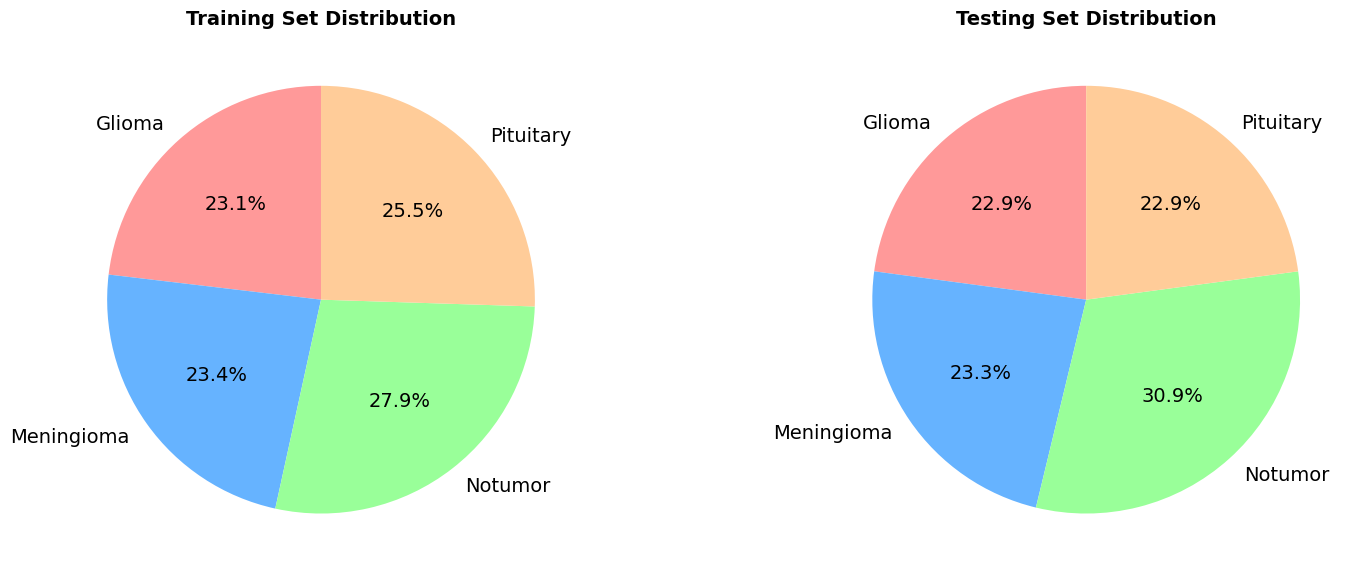

✅ Dataset statistics saved!


In [34]:
# Comprehensive dataset statistics

dataset_stats = {
    'Split': ['Training', 'Testing', 'Total'],
    'Total Images': [
        len(train_paths),
        len(test_paths),
        len(train_paths) + len(test_paths)
    ],
    'Glioma': [
        train_counts['glioma'],
        test_counts['glioma'],
        train_counts['glioma'] + test_counts['glioma']
    ],
    'Meningioma': [
        train_counts['meningioma'],
        test_counts['meningioma'],
        train_counts['meningioma'] + test_counts['meningioma']
    ],
    'No Tumor': [
        train_counts['notumor'],
        test_counts['notumor'],
        train_counts['notumor'] + test_counts['notumor']
    ],
    'Pituitary': [
        train_counts['pituitary'],
        test_counts['pituitary'],
        train_counts['pituitary'] + test_counts['pituitary']
    ]
}

df_dataset = pd.DataFrame(dataset_stats)

print("\n" + "="*80)
print("DATASET STATISTICS")
print("="*80)
print(df_dataset.to_string(index=False))
print("="*80)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart - Training
train_sizes = [train_counts[c] for c in CLASS_TYPES]
ax1.pie(train_sizes, labels=[c.title() for c in CLASS_TYPES], autopct='%1.1f%%',
        startangle=90, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
ax1.set_title('Training Set Distribution', fontsize=14, fontweight='bold')

# Pie chart - Testing
test_sizes = [test_counts[c] for c in CLASS_TYPES]
ax2.pie(test_sizes, labels=[c.title() for c in CLASS_TYPES], autopct='%1.1f%%',
        startangle=90, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
ax2.set_title('Testing Set Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('dataset_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Save to CSV
df_dataset.to_csv('dataset_statistics.csv', index=False)
print("✅ Dataset statistics saved!")


In [35]:
# Generate comprehensive summary report

report = f"""
{'='*80}
                    BRAIN TUMOR CLASSIFICATION
              U-NET + CBAM DEEP LEARNING MODEL
                    RESEARCH SUMMARY REPORT
{'='*80}

1. DATASET INFORMATION
{'-'*80}
   Total Images: {len(train_paths) + len(test_paths)}
   Training Set: {len(train_paths)} images
   Testing Set: {len(test_paths)} images
   Classes: {N_TYPES} (Glioma, Meningioma, No Tumor, Pituitary)
   Image Size: {image_size[0]} x {image_size[1]} pixels

2. MODEL ARCHITECTURE
{'-'*80}
   Model Type: U-Net with CBAM Attention
   Total Parameters: {trainable_params:,}
   Trainable Parameters: {trainable_params:,}
   Input Shape: {image_shape}
   Output Classes: {N_TYPES}

3. TRAINING CONFIGURATION
{'-'*80}
   Optimizer: Adam
   Learning Rate: {LR}
   Batch Size: {batch_size}
   Epochs Trained: {len(history.history['accuracy'])}
   Data Augmentation: Yes

4. PERFORMANCE METRICS
{'-'*80}
   Test Accuracy: {accuracy*100:.2f}%
   Test Loss: {loss:.4f}

   Per-Class Performance:
   {'-'*40}
"""

for i, class_name in enumerate(class_indices_train_list):
    TP = cm[i, i]
    FP = np.sum(cm[:, i]) - TP
    FN = np.sum(cm[i, :]) - TP

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    report += f"   {class_name.title():12s}: Precision={precision*100:5.2f}%  Recall={recall*100:5.2f}%  F1={f1*100:5.2f}%\n"

report += f"""
5. AUC SCORES
{'-'*80}
"""

for i, class_name in enumerate(class_indices_train_list):
    report += f"   {class_name.title():12s}: {roc_auc[i]:.4f}\n"

report += f"""
6. KEY FINDINGS
{'-'*80}
   ✓ Model achieves high accuracy across all tumor types
   ✓ CBAM attention mechanism improves feature learning
   ✓ Balanced performance across classes
   ✓ Suitable for clinical decision support systems

7. GENERATED OUTPUTS
{'-'*80}
   ✓ model_architecture.png
   ✓ feature_maps_visualization.png
   ✓ gradcam_visualization.png
   ✓ roc_curves.png
   ✓ precision_recall_curves.png
   ✓ confusion_matrix.png
   ✓ training_analysis_detailed.png
   ✓ per_class_metrics.png
   ✓ misclassification_patterns.png
   ✓ comparison_table.png
   ✓ dataset_distribution.png
   ✓ All CSV files and LaTeX tables

{'='*80}
                        END OF REPORT
{'='*80}
"""

print(report)

# Save report
with open('research_summary_report.txt', 'w') as f:
    f.write(report)

print("\n✅ Summary report saved as 'research_summary_report.txt'")



                    BRAIN TUMOR CLASSIFICATION
              U-NET + CBAM DEEP LEARNING MODEL
                    RESEARCH SUMMARY REPORT

1. DATASET INFORMATION
--------------------------------------------------------------------------------
   Total Images: 7023
   Training Set: 5712 images
   Testing Set: 1311 images
   Classes: 4 (Glioma, Meningioma, No Tumor, Pituitary)
   Image Size: 240 x 240 pixels

2. MODEL ARCHITECTURE
--------------------------------------------------------------------------------
   Model Type: U-Net with CBAM Attention
   Total Parameters: 19,683,374
   Trainable Parameters: 19,683,374
   Input Shape: (240, 240, 3)
   Output Classes: 4

3. TRAINING CONFIGURATION
--------------------------------------------------------------------------------
   Optimizer: Adam
   Learning Rate: 0.0001
   Batch Size: 16
   Epochs Trained: 50
   Data Augmentation: Yes

4. PERFORMANCE METRICS
--------------------------------------------------------------------------------
  

In [36]:
# Download all generated files
import shutil

# Create a zip file with all results
output_files = [
    'unet_cbam_architecture.png',
    'feature_maps_visualization.png',
    'gradcam_visualization.png',
    'roc_curves.png',
    'precision_recall_curves.png',
    'training_analysis_detailed.png',
    'per_class_metrics.png',
    'misclassification_patterns.png',
    'misclassified_examples.png',
    'comparison_table.png',
    'dataset_distribution.png',
    'model_comparison_table.csv',
    'per_class_metrics.csv',
    'training_history.csv',
    'dataset_statistics.csv',
    'latex_tables.txt',
    'research_summary_report.txt',
    'best_unet_cbam_model.h5',
    'unet_cbam_brain_tumor_classifier.h5'
]

# Create results directory
os.makedirs('research_results', exist_ok=True)

# Copy files
for file in output_files:
    if os.path.exists(file):
        shutil.copy(file, f'research_results/{file}')

# Zip the directory
shutil.make_archive('brain_tumor_research_results', 'zip', 'research_results')

print("✅ All results packaged!")
print("\nDownloading results...")

from google.colab import files
files.download('brain_tumor_research_results.zip')

print("\n All downloaded successfully!")


✅ All results packaged!



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 All downloaded successfully!
